# PCA analysis UKBB data

The intention of this notebook is to generate the PCA analysis and plots for the exomed samples 200K.

Steps to generate a PCA include removing related individuals, pruning variants in linkage disequilibrium (LD), and excluding outlier samples that can suggest poor genotyping quality or distant relatedness (also restrict to individuals of homogeneous ancestry).

Pitfalls
1. Some of the PCs may capture LD structure rather than population structure (decrease in power to detect associations in these regions of high LD)
2. When projecting a new study dataset to the PCA space computed from a reference dataset: projected PCs are shrunk toward 0 in the new dataset 
3.  PC scores may capture outliers that are due to family structure, population structure or other reasons; it might be beneficial to detect and remove these individuals to maximize the population structure captured by PCA (in the case of removing a few outliers) or to restrict analyses to genetically homogeneous samples


## PCA analysis pipeline

In [ ]:
[global]
# the output directory for generated files
parameter: cwd = path
# BED Plink files for exome data
parameter: bedfiles = paths
# BIM Plink files for exome data
parameter: bimfiles = paths
# The fam file associated to the bed files
parameter: famFile = path 
# The database to extract info from
parameter: database = path
# For cluster jobs, number commands to run per job
parameter: job_size = 1
# Number of threads
parameter: numThreads = 1
# Load Plink module from cluster
parameter: plink2_module = '''
module load PLINK/2_x86_64_20180428
echo "Module PLINK2 loaded"
{cmd}
'''
parameter: plink_module = '''
module load PLINK/1.90-beta5.3
echo "Module plink loaded"
{cmd}
'''
# Load Eigensoft module from cluster
parameter: eigensoft_module = '''
module load EIGENSOFT/7.2.1-foss-2018b
echo "Module Eigensoft v.7.2.1 loaded"
{cmd}
'''
# Software container option
parameter: container_lmm = 'statisticalgenetics/lmm:1.4'

In [ ]:
# Filter individuals from ancestries different than British, Irish, Other white background, prefer not to answer, do not know
[filter_1: provides = [f'{cwd}/cache/{famFile:bn}.white_ind']]
output: f'{cwd}/cache/{famFile:bn}.white_ind', f'{cwd}/cache/{famFile:bn}.white_ind.pheno'
task: trunk_workers = 1, walltime = '10h', mem = '40G', cores = numThreads, tags = f'{step_name}_{_output:bn}'
R: container=container_lmm, expand= "${ }", stderr = f'{_output[0]:nn}.stderr', stdout = f'{_output[0]:nn}.stdout'
    #Load libraries
    library('dplyr')
    # This database is the one from June 2020 and contains a subset of variables with the PCs
    fam <- read.table(${famFile:r}, sep=' ', header=F)
    colnames(fam) <- c("FID","IID","fatherID", "motherID", "sex", "phenotype")
    cat("There are",nrow(fam),"individuals with exomes.\n")
    bd <- read.table(${database:r}, sep="\t", header=T)
    cat("The size of the full database is",dim(bd),".\n")
    # Assign individual ID column to bd f.eid
    names(bd)[1] <- "IID"
    # Select the 200K individuals with exomes from the full db
    exomed_IID <- bd[bd$IID %in% fam$IID,]
    cat("The number of selected individuals is",nrow(exomed_IID),".\n")
    # Filter db based on ethnicity variable
    ethnicity <- exomed_IID %>%
          select(IID, starts_with("f.21000"))
    # Function to extract all the available answers for 3 visits and put them in one list
    f<-function(x){
      visit<-c()
      for (i in 2:4){
        if (!is.na(x[i]))
        {visit<-c(visit,x[i])}
      }
      if(is.null(visit)){visit=NA}
      else{visit=as.numeric(visit)}
      return (visit)
    }

    # Apply the above function and remove NAs
    ethnicity$visit<-apply(ethnicity, 1, f)
    # Filter out individuals wih missing values in ethnicity: 212 ind total
    ethnicity <- ethnicity %>%
      filter(!is.na(visit))
    cat("There are",nrow(ethnicity),"individuals without missing values for ethnicity.\n")
    # Identify the unique available codings in f.21000
    code<-union(union(unique(ethnicity$f.21000.0.0),unique(ethnicity$f.21000.1.0)),unique(ethnicity$f.21000.2.0))
    # Codes to keep white individuals
    useful_code<-c(1001,1002,1003,1,-3,-1)
    # the rest that don’t have the combinations above can be set as NA
    useless_code<-code[!code %in% useful_code] 
    useless_code<-useless_code[-which(is.na(useless_code))] # remove NA here in the vector
    # Function to get the final code for ethnicity
    f<-function(x){
      l=length(unique(x$visit))
      if (l==1){ # only one value available
        result=unique(x$visit)
      }
      else{ # more then one value available
        l=length(x$visit)
        for (i in 1:l){
          if (x$visit[i] %in% useless_code){result=NA; break} # inconsistent ones with conbination not wanted
          else {result=9000} # inconsistent ones with right conbination
        }
      }
      return(result)
    }

    # Apply the above function and remove NAs
    ethnicity$new_ethnicity<-apply(ethnicity, 1, f)
    # Filter by NA presence
    ethnicity_noNA<-ethnicity %>%
      filter(!is.na(new_ethnicity))
    cat("There are",nrow(ethnicity_noNA),"individuals consistent for f.21000.\n")
    ethnicity_isNA <- ethnicity %>%
      filter(is.na(new_ethnicity))
    cat("There are",nrow(ethnicity_isNA),"individuals inconsistent for f.21000.\n")
    # keep only white individuals
    white <- ethnicity_noNA %>%
        filter(new_ethnicity %in% c(1,1001,1002,1003,-3,-1,9000)) %>%
        mutate(FID = IID) %>%
        select(FID,IID)
    cat("After excluding non-white ethnic backgrounds, the number of white individuals is",nrow(white),".\n")
    # Write the seleted individuals to a txt file
    write.table(white,${_output[0]:r}, sep="\t", row.names=FALSE, col.names=F)
    # Create the phenotype file
    pheno <- ethnicity_noNA %>%
        filter(new_ethnicity %in% c(1,1001,1002,1003,-3,-1,9000)) %>%
        mutate(ethnicity = new_ethnicity) %>%
        select(IID,ethnicity)
    # Merge the two data frames
    famfile <-merge(fam, pheno, by="IID", all=FALSE)
    cat("The famfile has ",nrow(famfile),"individuals.\n")
    write.table(famfile,${_output[1]:r}, sep="\t", row.names=FALSE, col.names=F)

In [ ]:
# Filter SNPs with MAF>1% for PCA analysis, select individuals and merge bed into one file
[filter_2]
parameter: maf_filter = 0.01
#Maximum missingess per-variant
parameter: geno_filter = 0.01
#Maximum missingness per-sample
parameter: mind_filter = 0.02
parameter: hwe_filter = 0.0
input: bedfiles, paired_with=['bimfiles'], group_by=1
depends: f'{cwd}/cache/{famFile:bn}.white_ind'
output: f'{cwd}/{_input:bn}.filtered.bed'
task: trunk_workers = 1, walltime = '10h', mem = '30G', cores = numThreads, tags = f'{step_name}_{_output:bn}'
bash: container=container_lmm, expand= "${ }", stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout', template = '{cmd}' if executable('plink2').target_exists() else plink2_module
    plink2 \
      --bed ${_input}  --bim ${_input._bimfiles} --fam ${famFile} \
      ${('--maf %s' % maf_filter) if maf_filter > 0 else ''} ${('--geno %s' % geno_filter) if geno_filter > 0 else ''} ${('--hwe %s' % hwe_filter) if hwe_filter > 0 else ''} ${('--mind %s' % mind_filter) if mind_filter > 0 else ''} \
      --keep ${_depends} \
      --make-bed \
      --threads ${numThreads} \
      --out ${_output:n} 

In [ ]:
# Merge all the .bed files into one bed file for input to eigensoft
[filter_3]
input: group_by = 'all'
output: bfile_merge = f'{cwd}/{famFile:bn}.filtered.merged.bed'
task: trunk_workers = 1, trunk_size = job_size, walltime = '48h', mem = '60G', cores = numThreads, tags = f'{step_name}_{_output:bn}'
bash: expand= "${ }", stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout', template = '{cmd}' if executable('plink').target_exists() else plink_module
    echo -e ${' '.join([str(x)[:-4] for x in _input[1:]])} | sed 's/ /\n/g' > ${_output:n}.merge_list
    plink \
    --bfile ${_input[0]:n} \
    --merge-list ${_output:n}.merge_list \
    --make-bed \
    --out ${_output:n} \
    --threads ${numThreads} \
    --memory 48000

In [ ]:
# LD prunning window=50, shift-window every 5 SNPS, r2=0.5
[filter_4]
parameter: window = 50
parameter: shift = 5
parameter: r2 = 0.5
output: f'{cwd}/{famFile:bn}.filtered.merged.prune.in', f'{cwd}/{famFile:bn}.filtered.merged.prune.bed'
task: trunk_workers = 1, trunk_size = job_size, walltime = '48h', mem = '60G', cores = numThreads, tags = f'{step_name}_{_output:bn}'
bash: expand= "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout', template = '{cmd}' if executable('plink').target_exists() else plink_module
    plink \
    --bfile ${_input:n} \
    --indep-pairwise ${window} ${shift} ${r2}  \
    --out ${_output[0]:nn} \
    --threads ${numThreads} \
    --memory 48000
    
    plink \
    --bfile ${_input:n} \
    --extract ${_output[0]} \
    --make-bed \
    --out ${_output[1]:n} 

In [ ]:
# Run pca analysis using Eigenstrat: the program suports plink files here called PACKEDPED format
# smartpca.perl: run PCA on input genotype data (calls smartpca)
[pca_1]
# Number of Principal Components to output
parameter: k = int
# Maximum number of iterations for outlier removal. Default 0 turns off outlier removal
parameter: maxiter = 0
# Number of principal components along which to remove outliers during each outlier removal iteration. Default is 10
parameter: topk = 10
# Number of standard deviations which an individual must exceed, along one of topk top principal components, in order to be removed as an outlier. Default is 6
parameter: sigma = 6
input: f'{cwd}/{famFile:bn}.filtered.merged.bed'
output: f'{cwd}/{_input:bn}.convert.parfile' , 
        f'{cwd}/{_input:bn}.eigenstrat.parfile',
        f'{cwd}/{_input:bn}.snp', 
        f'{cwd}/{_input:bn}.ind', 
        f'{cwd}/{_input:bn}.geno', 
        f'{cwd}/{_input:bn}.evectout',
        f'{cwd}/{_input:bn}.evalout'
task: trunk_workers = 1, walltime = '24h', mem = '80G', cores = numThreads, tags = f'{step_name}_{_output:bn}'
bash: expand= "${ }", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout',  template = '{cmd}' if executable('smartpca.perl').target_exists() else eigensoft_module
  #Create the parfile
  #The famFile does not accept -9 make sure you change this before 
  set -e
  echo -e "genotypename: ${_input}" >> ${_output[0]}
  echo -e "snpname: ${_input:n}.bim" >> ${_output[0]}
  echo -e "indivname: ${_input:n}.eigenstrat.fam" >> ${_output[0]}
  echo -e "outputformat: EIGENSTRAT" >> ${_output[0]}
  echo -e "fastmode: YES" >> ${_output[0]}
  echo -e "genotypeoutname: ${_input:n}.geno" >> ${_output[0]}
  echo -e "snpoutname: ${_input:n}.snp" >> ${_output[0]}
  echo -e "indivoutname: ${_input:n}.ind" >> ${_output[0]}
  
  echo -e "genotypename: ${_input:n}.geno" >> ${_output[1]}
  echo -e "snpname: ${_input:n}.snp" >> ${_output[1]}
  echo -e "indivname: ${_input:n}.ind" >> ${_output[1]}
  echo -e "fastmode: YES" >> ${_output[1]}
  echo -e "evectoutname: ${_input:n}.evectout" >> ${_output[1]}
  echo -e "evaloutname: ${_input:n}.evalout" >> ${_output[1]} 
  echo -e "numoutevec: ${k}" >> ${_output[1]} 
  echo -e "numoutlieriter: ${maxiter}" >> ${_output[1]} 
  echo -e "numoutlierevec: ${topk}" >> ${_output[1]} 
  echo -e "outliersigmathresh: ${sigma}" >> ${_output[1]} 
  

bash: expand= "${ }", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout',  template = '{cmd}' if executable('smartpca.perl').target_exists() else eigensoft_module
   
   convertf -p ${_output[0]}
   
bash: expand= "${ }", stderr = f'{_output[1]}.stderr', stdout = f'{_output[1]}.stdout',  template = '{cmd}' if executable('smartpca.perl').target_exists() else eigensoft_module
  
   smartpca -p ${_output[1]}

In [1]:
# Test run using the smartpca.perl version without parameter file
#FIXME: error OOPS -a flag not specified at /gpfs/ysm/apps/software/EIGENSOFT/7.2.1-foss-2018b/bin/smartpca.perl line 21.
# /tmp/tmp5ywa_r4f.sh: line 4: -a: command not found
[smartpca]
# Number of Principal Components to output
parameter: k = int
# Maximum number of iterations for outlier removal. Default 0 turns off outlier removal
parameter: maxiter = 0
# Number of principal components along which to remove outliers during each outlier removal iteration. Default is 10
parameter: topk = 10
# Number of standard deviations which an individual must exceed, along one of topk top principal components, in order to be removed as an outlier. Default is 6
parameter: sigma = 6
input: f'{cwd}/{famFile:bn}.filtered.merged.geno'
output: f'{cwd}/{_input:bn}.eigenstrat.pca',
        f'{cwd}/{_input:bn}.eigenstrat.plot',
        f'{cwd}/{_input:bn}.eigenstrat.eigenvalues'
task: trunk_workers = 1, walltime = '24h', mem = '80G', cores = numThreads, tags = f'{step_name}_{_output[0]:bn}'
bash: expand= "${ }", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout',  template = '{cmd}' if executable('smartpca.perl').target_exists() else eigensoft_module

    smartpca.perl \
    -i ${_input} \ 
    -a ${_input:n}.snp \
    -b ${_input:n}.ind \
    -k ${k} \
    -o ${_output[0]} \
    -p ${_output[2]} \
    -e ${_output[1]} \
    -l ${_output[0]:n}.log \
    -m ${maxiter} \
    -t ${topk} \
    -s ${sigma}

In [ ]:
# Run PCA analysis using flashpca
[flashpca]
#Number of Principal Components to output. Default is 10
parameter: k = int
#How to standardize X before PCA
parameter: stand = "binom2"
input: f'{cwd}/{famFile:bn}.filtered.merged.prune.bed', f'{cwd}/cache/{famFile:bn}.white_ind.pheno'
output: f'{cwd}/{_input[0]:bn}.pca',
        f'{cwd}/{_input[0]:bn}.pc1vpc2.png',
        f'{cwd}/{_input[0]:bn}.pc3vpc4.png',
        f'{cwd}/{_input[0]:bn}.pc5vpc6.png' 
task: trunk_workers = 1, walltime = '10h', mem = '30G', cores = numThreads, tags = f'{step_name}_{_output[0]:bn}'
R: expand= "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout'
    # Load required libraries
    library(dplyr)
    library(ggplot2)
    library(flashpcaR)
    # Read the PLINK binary files
    fn <- ${_input[0]:nr}
    # Do the PCA computation
    f <- flashpca(fn, ndim=${k}, stand="${stand}", do_loadings=TRUE, check_geno=TRUE)
    # Save the generated matrices to files
    write.table(f$values,'${_output[0]:n}.values', sep=" ", row.names=FALSE, col.names=F) 
    write.table(f$vectors,'${_output[0]:n}.vectors', sep=" ", row.names=TRUE, col.names=F)
    write.table(f$projection,'${_output[0]:n}.projection', sep=" ", row.names=TRUE, col.names=F)
    write.table(f$loadings,'${_output[0]:n}.loadings', sep=" ", row.names=FALSE, col.names=F)
    write.table(f$scale,'${_output[0]:n}.scale', sep=" ", row.names=FALSE, col.names=F)
    # Use the projection file to generate plot
    pca <- read.table('${_output[0]:n}.projection', sep=" ")
    colnames(pca) <- c("ID","PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10")
    pca$IID <- sapply(strsplit(as.character(pca$ID),':'), "[", 1)
    # Read fam file with phenotypes
    fam <- read.table(${famFile:r}, sep=" ")
    colnames(fam) <- c("FID", "IID", "father", "mother","sex", "pheno")
    ind <-merge(fam, pca, by="IID", all=TRUE)
    # Read the file with ethnicity values
    ethnicity <- read.table(${_input[1]:r}, sep="\t" )
    colnames(ethnicity) <- c("FID", "IID", "father", "mother","sex", "pheno", "ethnicity")
    # Create the final PCA + ethnicity file
    pca_final <-merge(ind, ethnicity, by="IID",all.y=FALSE)
    pca_final_r <- pca_final %>% 
        mutate(ethnicity_1 = case_when(
             ethnicity == 1001 ~  "British",
             ethnicity == 1002 ~ "Irish",
             ethnicity == 1003 ~ "Any other white background",
             ethnicity == 9000 ~ "Inconsistent_white",
             ethnicity == 1 ~ "White",
             ethnicity == -1 ~ "Do not know",
             ethnicity == -3 ~ "Prefer not to answer",
             TRUE  ~ ""))
    write.table(pca_final_r,${_output[0]:r}, sep="\t", quote=FALSE, row.names=FALSE, col.names=T)
  
    png('${_output[1]}', width = 6, height = 4, unit='in', res=300)
    ggplot(pca_final_r, aes(x=PC1, y=PC2)) + geom_point(aes(color=ethnicity_1)) + labs(title="PC1 vs PC2 exomed subset white",x="PC1", y = "PC2") + theme_classic()
    dev.off()
  
    png('${_output[2]}', width = 6, height = 4, unit='in', res=300)
    ggplot(pca_final_r, aes(x=PC3, y=PC4)) + geom_point(aes(color=ethnicity_1)) + labs(title="PC3 vs PC4 exomed subset white", x="PC3", y = "PC4") + theme_classic()
    dev.off()
    
    png('${_output[3]}', width = 6, height = 4, unit='in', res=300)
    ggplot(pca_final_r, aes(x=PC5, y=PC6)) + geom_point(aes(color=ethnicity_1)) + labs(title="P5 vs PC6 exomed subset white",x="PC5", y = "PC6") + theme_classic()
    dev.off()           

# Calculate mahalanobis distance to remove outliers

In [1]:
setwd("/gpfs/gibbs/pi/dewan/data/UKBiobank/results/pca_exomes")
pca <- read.csv("ukb23155_s200631.filtered.merged.prune.pca", sep='\t')
head(pca)

,IID,FID.x,father.x,mother.x,sex.x,pheno.x,ID,PC1,PC2,PC3,⋯,PC8,PC9,PC10,FID.y,father.y,mother.y,sex.y,pheno.y,ethnicity,ethnicity_1
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>
1,1000019,1000019,0,0,2,-9,1000019:1000019,0.01553941,0.02393847,-0.007491376,⋯,-0.0008964522,0.005746197,-0.001042337,1000019,0,0,2,-9,1001,British
2,1000035,1000035,0,0,1,-9,1000035:1000035,0.01253709,-0.02193925,0.003917083,⋯,-0.0101081273,0.003216692,-0.011721235,1000035,0,0,1,-9,1001,British
3,1000078,1000078,0,0,2,-9,1000078:1000078,0.01497620,0.01950002,0.013263954,⋯,0.0199936269,-0.004632490,-0.004389401,1000078,0,0,2,-9,1001,British
4,1000081,1000081,0,0,1,-9,1000081:1000081,-0.12213015,0.03863465,0.003532455,⋯,-0.0108502715,0.015511705,0.006788431,1000081,0,0,1,-9,1001,British
5,1000198,1000198,0,0,2,-9,1000198:1000198,0.01218179,0.02232563,-0.007680613,⋯,-0.0026506194,-0.012875036,0.004556960,1000198,0,0,2,-9,1001,British
6,1000210,1000210,0,0,1,-9,1000210:1000210,0.02526840,0.03664394,0.001277694,⋯,-0.0023364127,0.016794410,-0.012663409,1000210,0,0,1,-9,1001,British


In [2]:
library(dplyr)
pc = pca %>%
    select("IID", "ethnicity_1", starts_with("PC"),)
head(pc)
nrow(pc)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




,IID,ethnicity_1,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1000019,British,0.01553941,0.02393847,-0.007491376,-0.005710133,0.008875987,-0.000270289,-0.0002785837,-0.0008964522,0.005746197,-0.001042337
2,1000035,British,0.01253709,-0.02193925,0.003917083,0.006284067,-0.010311789,0.025505354,-0.0069599583,-0.0101081273,0.003216692,-0.011721235
3,1000078,British,0.01497620,0.01950002,0.013263954,-0.018580038,0.006379030,-0.001985547,0.0100692105,0.0199936269,-0.004632490,-0.004389401
4,1000081,British,-0.12213015,0.03863465,0.003532455,-0.002797373,-0.017269542,-0.017946452,-0.0181935503,-0.0108502715,0.015511705,0.006788431
5,1000198,British,0.01218179,0.02232563,-0.007680613,0.002397714,-0.023268540,0.010575808,-0.0021913240,-0.0026506194,-0.012875036,0.004556960
6,1000210,British,0.02526840,0.03664394,0.001277694,-0.004001638,-0.003573630,0.015393983,0.0034119557,-0.0023364127,0.016794410,-0.012663409


[1] 189016

In [3]:
# calculate covariance of the features
PC_cov = cov(pc[,3:12])
head(PC_cov)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
PC1,5.421522e-04,-2.028804e-19,1.321268e-19,-7.259620e-20,4.653568e-20,-5.268156e-21,1.590150e-20,1.516786e-20,-1.785426e-20,3.954513e-21
PC2,-2.028804e-19,4.759236e-04,2.624618e-19,-5.135812e-20,-2.038693e-19,1.304438e-20,-1.149791e-20,1.245990e-19,-4.171724e-20,1.209127e-20
PC3,1.321268e-19,2.624618e-19,3.091152e-04,8.682135e-19,-1.053246e-19,-2.983784e-22,3.061795e-21,2.000894e-21,-1.256077e-19,2.692803e-20
PC4,-7.259620e-20,-5.135812e-20,8.682135e-19,2.925158e-04,7.200688e-19,-1.125105e-20,5.215969e-20,-2.465964e-19,-8.403623e-20,1.469338e-20
PC5,4.653568e-20,-2.038693e-19,-1.053246e-19,7.200688e-19,2.559794e-04,1.551328e-20,6.487266e-21,1.563918e-19,-1.609577e-19,3.474968e-20
PC6,-5.268156e-21,1.304438e-20,-2.983784e-22,-1.125105e-20,1.551328e-20,2.511973e-04,9.367256e-20,5.352686e-20,1.554402e-20,-3.532764e-21


In [4]:
# Find the inverse of the covariance matrix
inv_PC_cov = solve(PC_cov)
head(inv_PC_cov )

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
PC1,1.844501e+03,7.862881e-13,-7.884047e-13,4.577658e-13,-3.353203e-13,3.868320e-14,-1.243873e-13,-1.277873e-13,1.684596e-13,-3.759058e-14
PC2,7.862881e-13,2.101177e+03,-1.784056e-12,3.689118e-13,1.673438e-12,-1.091117e-13,1.024568e-13,-1.195809e-12,4.483873e-13,-1.309308e-13
PC3,-7.884047e-13,-1.784056e-12,3.235040e+03,-9.601893e-12,1.331080e-12,3.842660e-15,-4.200633e-14,-2.956571e-14,2.078600e-12,-4.489433e-13
PC4,4.577658e-13,3.689118e-13,-9.601893e-12,3.418619e+03,-9.616556e-12,1.531189e-13,-7.562140e-13,3.850544e-12,1.469577e-12,-2.588687e-13
PC5,-3.353203e-13,1.673438e-12,1.331080e-12,-9.616556e-12,3.906564e+03,-2.412590e-13,-1.074770e-13,-2.790575e-12,3.216486e-12,-6.996052e-13
PC6,3.868320e-14,-1.091117e-13,3.842660e-15,1.531189e-13,-2.412590e-13,3.980934e+03,-1.581453e-12,-9.732882e-13,-3.165361e-13,7.247811e-14


In [5]:
# Calculate the mean for each variable
PC_mean=apply(pc[,3:12], 2, mean)
head(PC_mean)

PC1           PC2           PC3           PC4           PC5 
-3.202909e-18 -1.909373e-17 -1.743195e-18 -9.957463e-18 -1.537211e-17 
          PC6 
 3.848268e-19

In [ ]:
manha_dis_sq = apply(pc[,3:12], 1, FUN=function(x){t(x-PC_mean)%*% inv_PC_cov %*% (x-PC_mean)})
manha_dis_sq

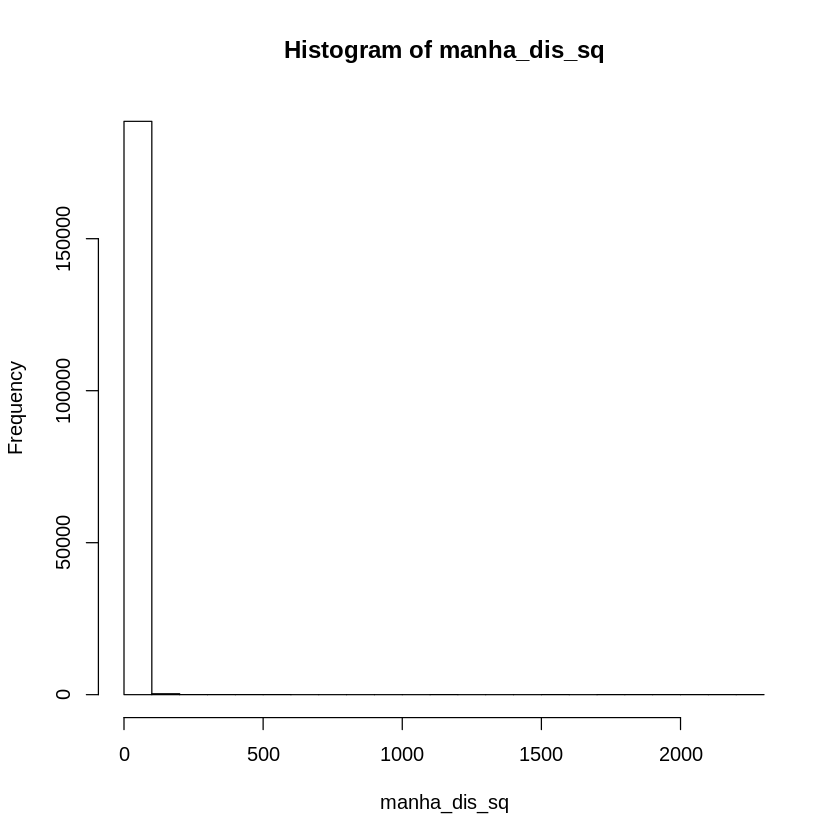

In [32]:
hist(manha_dis_sq)

In [45]:
sd(manha_dis_sq)

[1] 36.30221

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 1 rows containing missing values (geom_bar).”


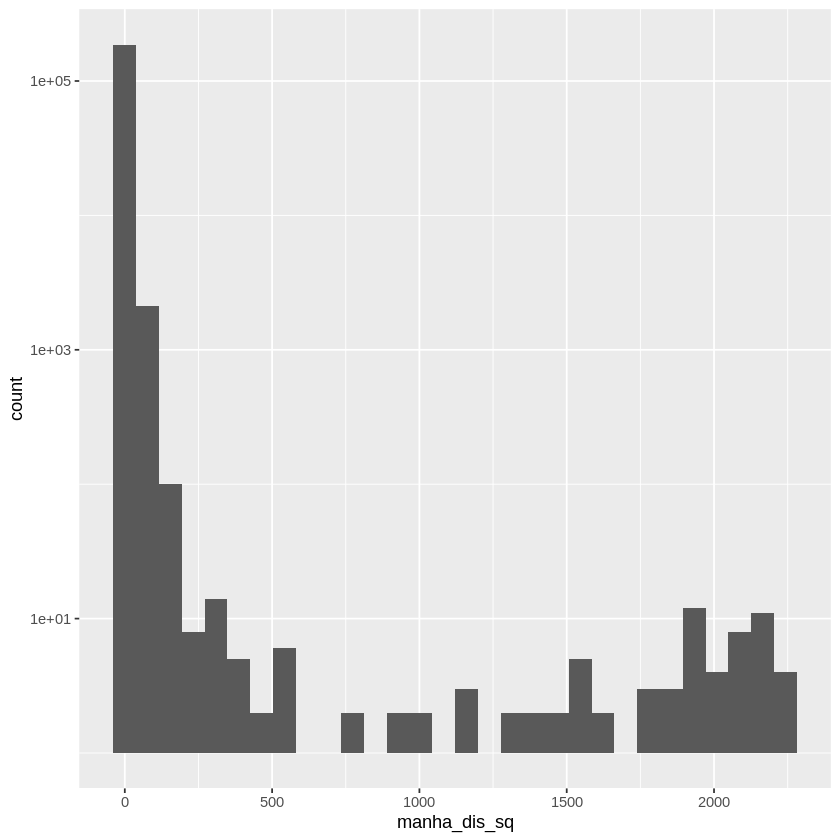

In [34]:
ggplot() + geom_histogram(aes(manha_dis_sq)) + scale_y_log10()


In [41]:
length(which(manha_dis_sq >= manh_dis_sq_cutoff))

[1] 568

In [42]:
length(which(manha_dis_sq <= manh_dis_sq_cutoff))

[1] 188448

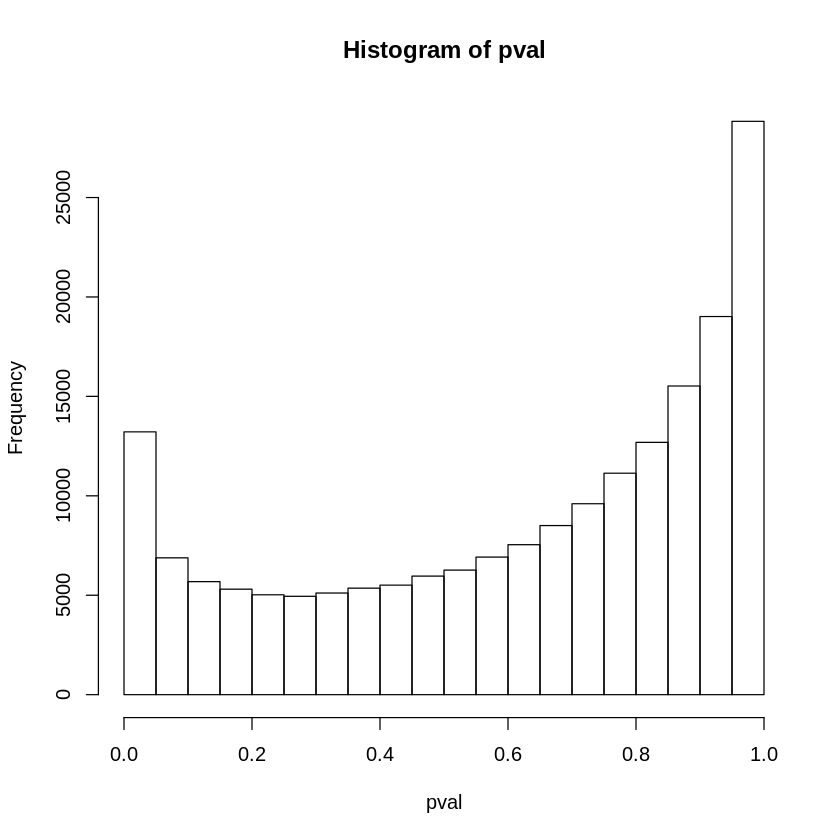

In [7]:
pval <- pchisq(manha_dis_sq, df =10, lower.tail = FALSE)
hist(pval)

In [8]:
is.out <- (pval < (0.05 / length(manha_dis_sq)))  # Bonferroni correction
sum(is.out)

[1] 1799

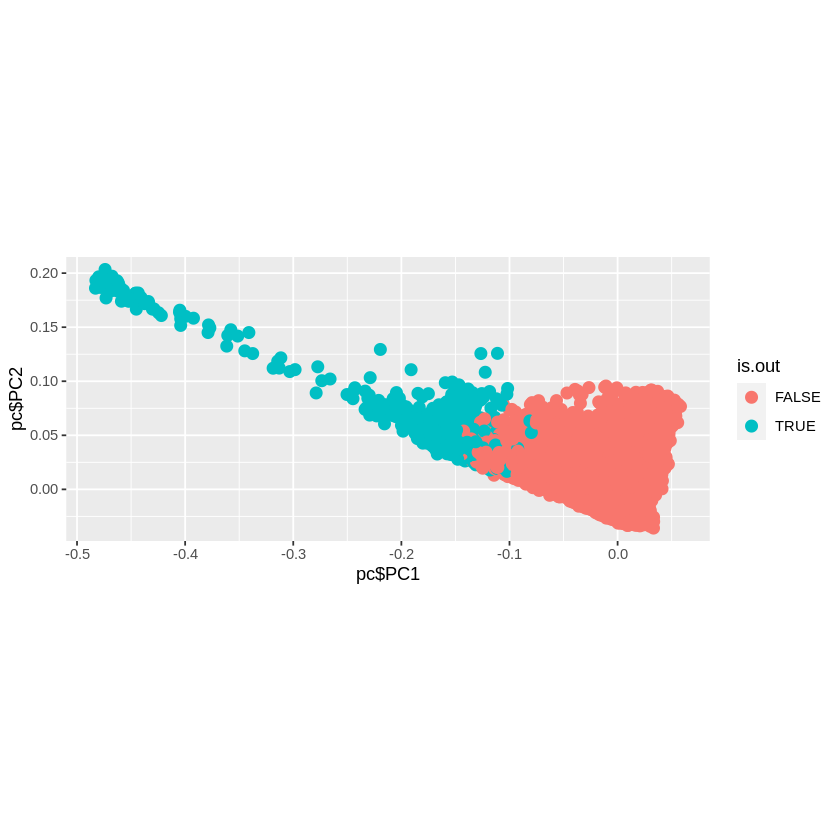

In [9]:
library(ggplot2)
qplot(pc$PC1, pc$PC2, color = is.out, size = I(3)) + coord_equal()

In [10]:
manh_dis_sq_cutoff = quantile(manha_dis_sq,probs = 0.997) #6 sd from the mean chi-square double sided
manh_dis_sq_cutoff

99.7% 
94.11918

In [11]:
max(manha_dis_sq)

[1] 2242.002

In [12]:
#Sample without outliers
new_sample = pc[(manha_dis_sq <= manh_dis_sq_cutoff),1]
length(new_sample)
head(new_sample)

[1] 188448

[1] 1000019 1000035 1000078 1000081 1000198 1000210

In [13]:
# removed those NAs and inconsistent cases: 
IID_removed_outlier<-pca %>%
  filter((IID%in%new_sample)) %>%
  mutate(FID = IID) %>%
  select(FID, IID, starts_with("PC"), ethnicity_1)
nrow(IID_removed_outlier)
head(IID_removed_outlier)

[1] 188448

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,ethnicity_1
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,1000019,1000019,0.01553941,0.02393847,-0.007491376,-0.005710133,0.008875987,-0.000270289,-0.0002785837,-0.0008964522,0.005746197,-0.001042337,British
2,1000035,1000035,0.01253709,-0.02193925,0.003917083,0.006284067,-0.010311789,0.025505354,-0.0069599583,-0.0101081273,0.003216692,-0.011721235,British
3,1000078,1000078,0.01497620,0.01950002,0.013263954,-0.018580038,0.006379030,-0.001985547,0.0100692105,0.0199936269,-0.004632490,-0.004389401,British
4,1000081,1000081,-0.12213015,0.03863465,0.003532455,-0.002797373,-0.017269542,-0.017946452,-0.0181935503,-0.0108502715,0.015511705,0.006788431,British
5,1000198,1000198,0.01218179,0.02232563,-0.007680613,0.002397714,-0.023268540,0.010575808,-0.0021913240,-0.0026506194,-0.012875036,0.004556960,British
6,1000210,1000210,0.02526840,0.03664394,0.001277694,-0.004001638,-0.003573630,0.015393983,0.0034119557,-0.0023364127,0.016794410,-0.012663409,British


In [14]:
library(ggplot2)
png('ukb23155_s200631.filtered.merged.prune.pc1vpc2.outliers_removed.png', width = 6, height = 4, unit='in', res=300)
ggplot(IID_removed_outlier, aes(x=PC1, y=PC2))+ geom_point(aes(color=ethnicity_1, shape=ethnicity_1), size=2) +
    labs(title="P1 vs PC2 exomes N=188,488",
       x="PC1", y = "PC2") + scale_shape_manual(values=c(0,1,2,3,4,5,8)) +
    theme_classic()
dev.off()

png 
  2

In [17]:
png('ukb23155_s200631.filtered.merged.prune.pc3vpc4.outliers_removed.png', width = 6, height = 4, unit='in', res=300)
ggplot(IID_removed_outlier, aes(x=PC3, y=PC4))+ geom_point(aes(color=ethnicity_1, shape=ethnicity_1), size=2) +
    labs(title="P3 vs PC4 exomes N=188,488",
       x="PC3", y = "PC4") + scale_shape_manual(values=c(0,1,2,3,4,5,8)) +
    theme_classic()
dev.off()

png 
  2

In [18]:
png('ukb23155_s200631.filtered.merged.prune.pc5vpc6.outliers_removed.png', width = 6, height = 4, unit='in', res=300)
ggplot(IID_removed_outlier, aes(x=PC5, y=PC6))+ geom_point(aes(color=ethnicity_1, shape=ethnicity_1), size=2) +
    labs(title="P5 vs PC6 exomes N=188,488",
       x="PC5", y = "PC6") + scale_shape_manual(values=c(0,1,2,3,4,5,8)) +
    theme_classic()
dev.off()

png 
  2

In [112]:
# output sampleIID with outlier removal
write.table(IID_removed_outlier,"exome_IID_188448_outliers_removed.txt",col.names = F,row.names = F,quote = F)

In [81]:
include = (manha_dis_sq <= manh_dis_sq_cutoff)+1
length(include) #528 individuals excluded

[1] 189016

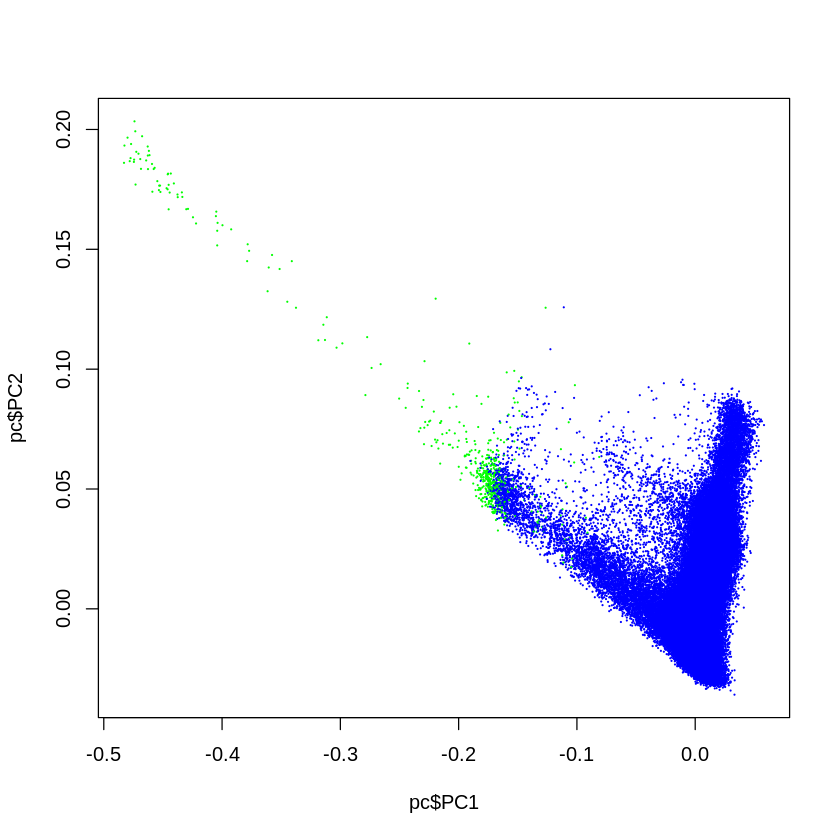

In [107]:
plot(pc$PC1,pc$PC2,col=c("green","blue")[include],cex = .1)

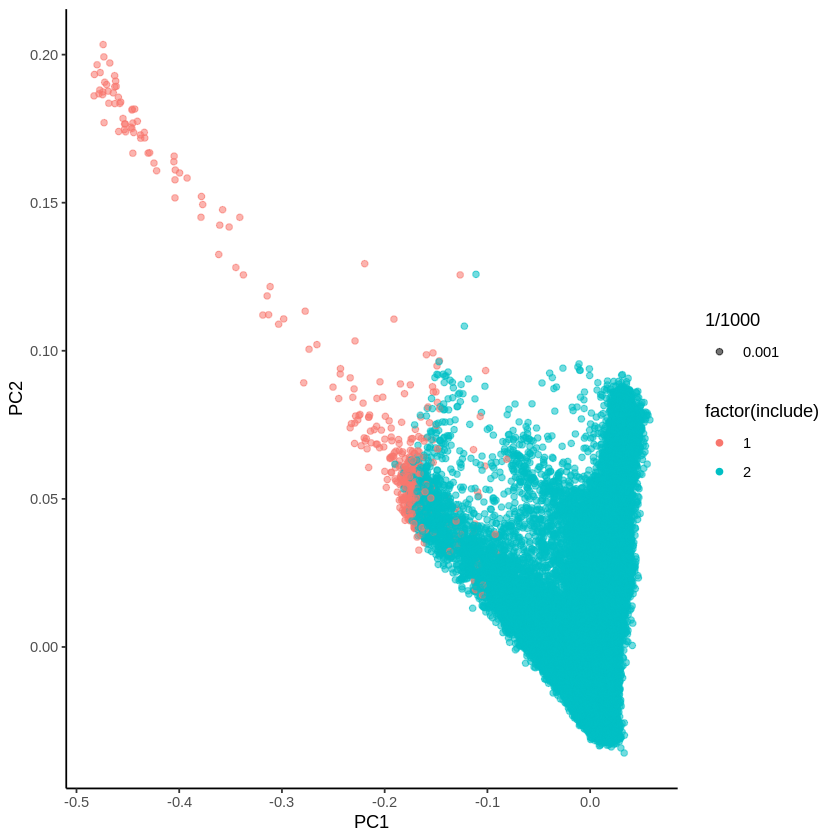

In [105]:
ggplot(pc,aes(x=PC1,PC2)) +  geom_point(aes(color=factor(include),alpha=1/1000)) +
    theme_classic()

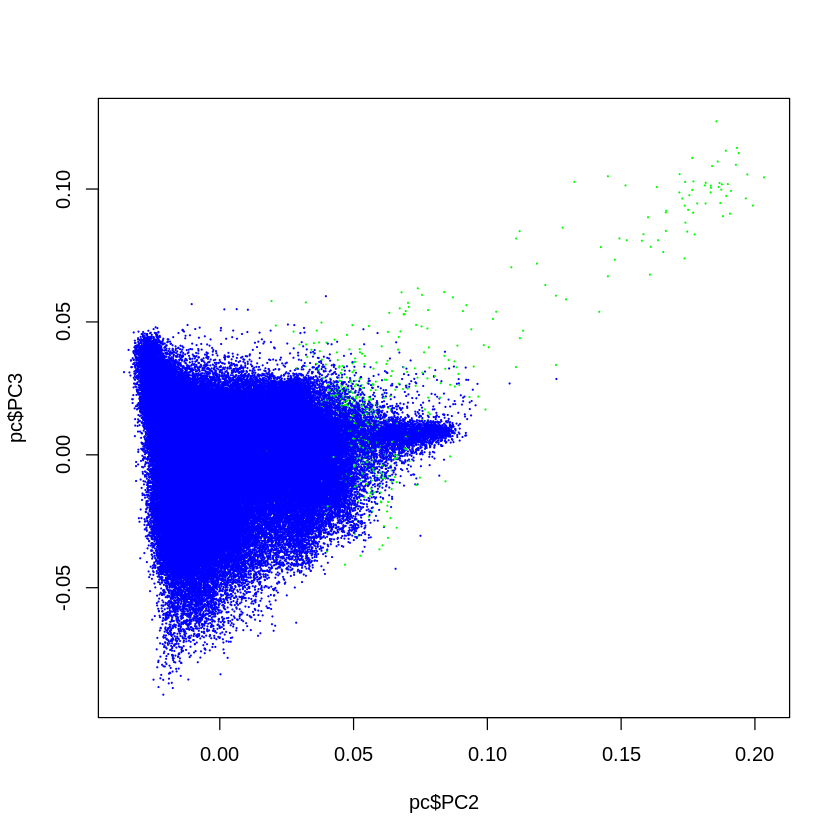

In [108]:
plot(pc$PC2,pc$PC3,col=c("green","blue")[include],cex = .1)

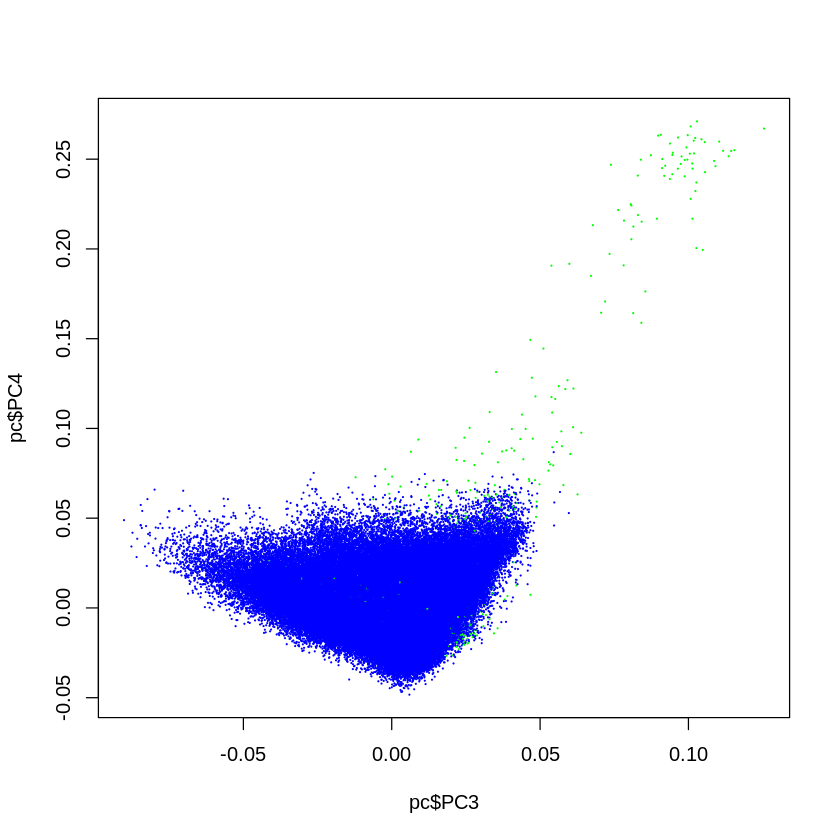

In [109]:
plot(pc$PC3,pc$PC4,col=c("green","blue")[include],cex = .1)

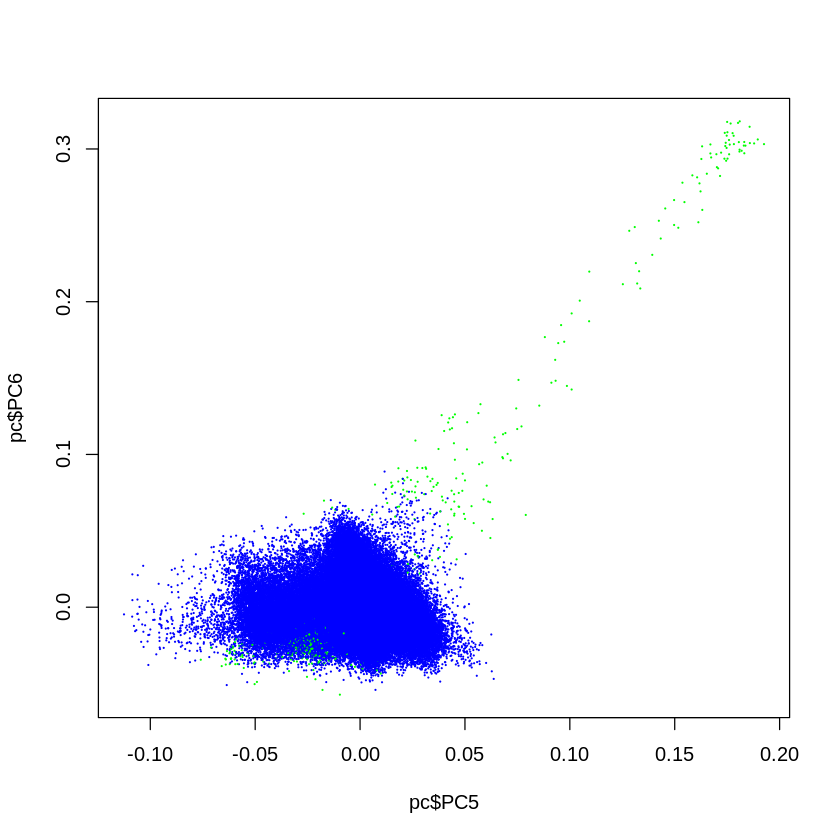

In [110]:
plot(pc$PC5,pc$PC6,col=c("green","blue")[include],cex = .1)

In [29]:
pnorm(3)

[1] 0.9986501

In [27]:
1-pchisq(26.833, 10, lower.tail=FALSE)
pchisq(26.833, 10, lower.tail=FALSE)

[1] 0.9972325

[1] 0.002767512

In [40]:
qchisq(0.997, 10, lower.tail=TRUE)

[1] 26.61079